Load Model

In [1]:
import os
import sys
import re
import gc
import platform
import random

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import einops

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split


import timm
import glob
import cv2

from rich import print as _pprint
from rich.progress import track
import albumentations as A
from albumentations.pytorch import ToTensorV2

import wandb

import warnings
warnings.simplefilter('ignore')

In [4]:

from config import * 

from dataset import VideoDataset

from efficientnet_lite3 import ESNAModel



In [5]:
model=ESNAModel()

if torch.cuda.is_available():
    device=torch.device('cuda')
    model=model.to(device)
    
    
model_path = '/home/irteam/junghye-dcloud-dir/dscapstone/ResNext/models/model_efficientnet_lite3_2_15.pt'  # 모델 파일 경로
model.load_state_dict(torch.load(model_path))
model.eval()

ESNAModel(
  (backbone): EfficientNetLite3Model(
    (backbone): EfficientNet(
      (conv_stem): Conv2dSame(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU6(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): ReLU6(inplace=True)
            )
            (se): Identity()
            (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNormAct2d(
              24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Ide

In [6]:
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score, roc_auc_score
from sklearn.metrics import roc_curve

@torch.no_grad()
def test_with_roc(model, test_dataloader, device, threshold=0.5,verbose=False):
    model.eval()
    
    all_targets = []
    all_preds = []
    
    prog_bar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
    for batch, (frames, targets) in prog_bar:
        frames = frames.to(device, torch.float)
        targets = targets.to(device, torch.float)

        frames = einops.rearrange(frames, 'b h w f -> b f h w')

        preds = model(frames)
        #print(f'preds:{preds}')
       
        #print(f'sigmoids_preds:{preds.sigmoid()}')
        all_targets.append(targets.cpu().numpy())
        
        # preds는 로짓 값이므로 sigmoid 함수를 적용하여 확률 값으로 변환
        all_preds.append(preds.sigmoid().cpu().numpy())

        
    all_targets = np.concatenate(all_targets)
    all_preds = np.concatenate(all_preds)
    

    all_preds_bin=np.zeros_like(all_preds)
    all_preds_bin[np.arange(len(all_preds)), np.argmax(all_preds, axis=1)] = 1
     
    
    print(all_preds_bin)
    accuracy = accuracy_score(all_targets, all_preds_bin)
    precision = precision_score(all_targets, all_preds_bin, average='weighted')
    recall = recall_score(all_targets, all_preds_bin, average='weighted')
    f1 = f1_score(all_targets, all_preds_bin, average='weighted')

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }


    roc_auc = {}
    for class_name,index in classes.items():
        roc_auc[class_name] = roc_auc_score(all_targets[:, index], all_preds[:, index])

   # wandb.log({
        #"avg_val_loss": round(avg_val_loss, 4),
        #"roc_auc_scores": roc_auc
    #})
    #fpr,tpr,thresholds=roc_curve(all_targets,al)
    
    

    return  roc_auc,metrics,all_targets,all_preds,all_preds_bin




In [7]:
def collate_fn(batch):
    max_frames=Config['MAX_FRAMES']
    
    padded_frames=[]
    labels=[]
    
    for frames,label in batch:
        padded = np.pad(frames, ((0, 0), (0, max_frames - frames.shape[1]), (0, 0)), mode='constant', constant_values=0)
        padded_frames.append(padded)
        labels.append(label)
        
    padded_frames=np.stack(padded_frames,axis=0)
    labels=np.stack(labels,axis=0)
   # labels=torch.tensor(labels)
    return torch.from_numpy(padded_frames).float(),torch.from_numpy(labels).float()

In [8]:
class Augments:
    train_augments=A.Compose([
        ToTensorV2(p=1.0),
    ],p=1.)
    
    valid_augments=A.Compose([
        ToTensorV2(p=1.0),
    ],p=1.)

valid_ann=pd.read_csv('/home/irteam/junghye-dcloud-dir/dscapstone/video2frames_AllFrames_NormalIncluded/new_test_anno.csv')
valid_dataset=VideoDataset(valid_ann,classes,Augments.valid_augments,is_test=False)

valid_loader=DataLoader(
    valid_dataset,
    batch_size=Config['VALID_BS'],
    shuffle=False,
    num_workers=Config['NUM_WORKERS'],
    collate_fn=collate_fn
)

# 사용 예시
roc_auc_scores,metric_scores,all_targets,all_preds,all_preds_bin = test_with_roc(model, valid_loader, device=device)
print(roc_auc_scores)

print(metric_scores)

100%|██████████| 57/57 [01:21<00:00,  1.43s/it]

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 

In [9]:
from sklearn.metrics import roc_curve, auc
fpr_list = []
tpr_list = []
threshold_list = []
roc_auc_list = []

for i in range(2): # you can make this more general
    fpr, tpr, threshold = roc_curve(all_targets[:, i], all_preds[:, i])
    roc_auc = auc(fpr, tpr)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    threshold_list.append(threshold)
    roc_auc_list.append(roc_auc)

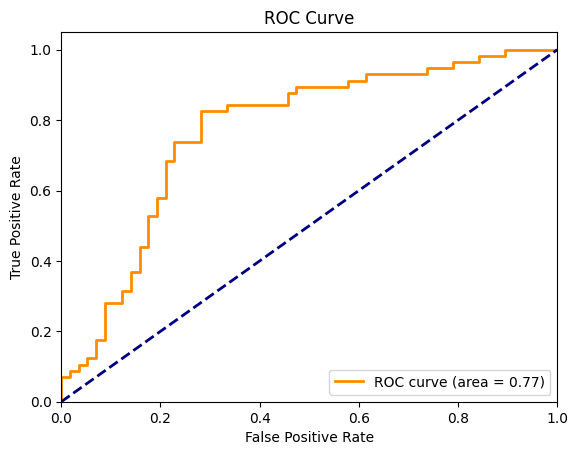

In [10]:
import matplotlib.pyplot as plt

# 양성 클래스(보통 라벨 1)에 대한 ROC 곡선 그리기
plt.figure()
plt.plot(fpr_list[1], tpr_list[1], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_list[1])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

